In [1]:
import os

import numpy as np

import timm
import torch
import torch.nn as nn
import torchvision

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from PIL import Image

import matplotlib.pyplot as plt
import copy

import coremltools as ct

In [2]:
class WrapperModel(nn.Module):
    def __init__(self, model_name: str = 'mobilenetv2_100', mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        super(WrapperModel, self).__init__()
        
        self.model = timm.create_model(model_name=model_name, pretrained=True, ).eval()
        
        self.normalize = torchvision.transforms.Normalize(mean=mean, std=std)
    
    def forward(self, x):
        y = x / 255
        y = self.normalize(y)
        out = self.model(y)
        probabilities = torch.nn.functional.softmax(out[0], dim=0)
        
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        
        return top5_prob, top5_catid.int()

In [3]:
model_name = 'tf_efficientnet_b0_ns'
model = timm.create_model(model_name=model_name, pretrained=True, )

config = resolve_data_config({}, model=model)
transform = create_transform(**config)
transform.transforms[-1]

Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))

In [4]:
transform.transforms[-1].mean, transform.transforms[-1].std

(tensor([0.4850, 0.4560, 0.4060]), tensor([0.2290, 0.2240, 0.2250]))

In [5]:
model = WrapperModel(
    model_name=model_name,
    mean=transform.transforms[-1].mean,
    std=transform.transforms[-1].std,
).eval()

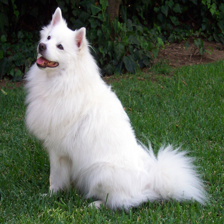

In [6]:
img = Image.open('dog.jpg').convert('RGB')
img.resize((224, 224))

In [12]:
img_input = torch.from_numpy(np.asarray(img.copy().resize((224, 224), Image.BICUBIC))).permute(2, 0, 1).float().unsqueeze(0)
img_input.shape

torch.Size([1, 3, 224, 224])

In [13]:
with torch.no_grad():
    out = model(img_input)

out

(tensor([0.5155, 0.1559, 0.0144, 0.0094, 0.0078]),
 tensor([258, 259, 261, 270, 279], dtype=torch.int32))

Для первых 5-и

In [14]:
out[0].sum()

tensor(0.7029)

In [15]:
# для xcit
def replace_batchnorm(net):
    for child_name, child in net.named_children():
        if hasattr(child, 'fuse'):
            setattr(net, child_name, child.fuse())
        elif isinstance(child, torch.nn.Conv2d):
            child.bias = torch.nn.Parameter(torch.zeros(child.weight.size(0)))
        elif isinstance(child, torch.nn.BatchNorm2d):
            setattr(net, child_name, torch.nn.Identity())
        else:
            replace_batchnorm(child)

In [16]:
# replace_batchnorm(model)

In [19]:
with torch.no_grad():
    traced_model = torch.jit.trace(copy.deepcopy(model), torch.rand(1, 3, 224, 224), )
    out2 = traced_model(img_input)

out2

(tensor([0.5155, 0.1559, 0.0144, 0.0094, 0.0078]),
 tensor([258, 259, 261, 270, 279], dtype=torch.int32))

In [20]:
out[0].eq(out2[0]), out[1].eq(out2[1])

(tensor([True, True, True, True, True]),
 tensor([True, True, True, True, True]))

In [21]:
model_ct = ct.convert(
    traced_model,
    inputs=[
        ct.ImageType( 
            name="image", 
            shape=(1, 3, 224, 224),
        )
    ],
)

Running MIL Common passes:   0%|          | 0/34 [00:00<?, ? passes/s]/Users/kasevgen/opt/anaconda3/envs/benchmark/lib/python3.7/site-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '1313_0', of the source model, has been renamed to 'var_1313_0' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
/Users/kasevgen/opt/anaconda3/envs/benchmark/lib/python3.7/site-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '1319', of the source model, has been renamed to 'var_1319' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 752/752 [00:00<00:00, 1842.13 ops/s]


In [22]:
print(model_ct.output_description)
spec = model_ct.get_spec()

Features(var_1313_0,var_1319)


In [23]:
spec.description.output[0].name

'var_1313_0'

In [24]:
ct.utils.rename_feature(spec, spec.description.output[0].name, 'probs')
ct.utils.rename_feature(spec, spec.description.output[1].name, 'indices')

In [25]:
ct_model = ct.models.MLModel(spec)

In [26]:
out2

(tensor([0.5155, 0.1559, 0.0144, 0.0094, 0.0078]),
 tensor([258, 259, 261, 270, 279], dtype=torch.int32))

In [27]:
ct_model.predict({'image': Image.open('dog.jpg').resize((224, 224), Image.BICUBIC)})

{'indices': array([258., 259., 261., 270., 279.], dtype=float32),
 'probs': array([0.51708984, 0.15356445, 0.01450348, 0.00938416, 0.00780106],
       dtype=float32)}

In [28]:
ct_model.save(os.getcwd() + f'/MLmodels/{model_name}.mlmodel')